In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

users_df = pd.read_json("users.json")
tracks_df = pd.read_json("tracks.json")
artists_df = pd.read_json("artists.json")
sessions_df = pd.read_json("sessions.json")

## Analiza zbiorów danych

### Plik users.json

In [52]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           954 non-null    int64 
 1   name              954 non-null    object
 2   city              954 non-null    object
 3   street            954 non-null    object
 4   favourite_genres  954 non-null    object
 5   premium_user      954 non-null    bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 38.3+ KB


In [53]:
print("Number of uniqe values: ", users_df.loc[:,'user_id'].nunique(), "\nNumber of values: ", users_df.loc[:,'user_id'].size)

Number of uniqe values:  954 
Number of values:  954


<AxesSubplot:xlabel='premium_user', ylabel='count'>

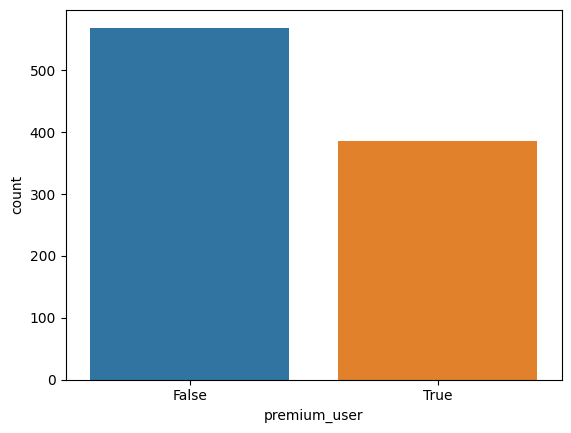

In [54]:
sns.countplot(data=users_df, x='premium_user')


<BarContainer object of 50 artists>

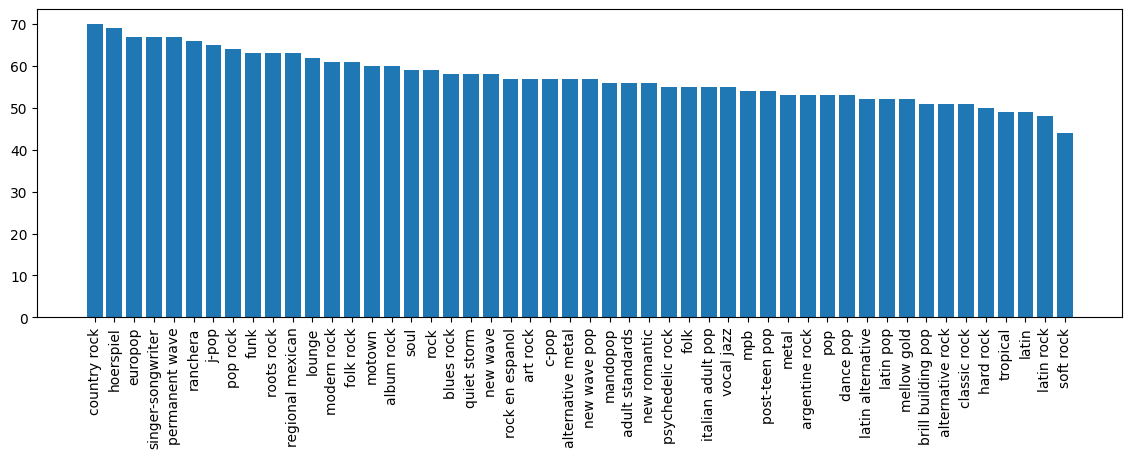

In [55]:
def to_1D(series):
  return pd.Series([x for _list in series for x in _list])

users_df.favourite_genres.fillna('', inplace=True)
unique_values = to_1D(users_df["favourite_genres"]).value_counts().index.tolist()
unique_value_counts = to_1D(users_df["favourite_genres"]).value_counts().values

fig, ax = plt.subplots(figsize = (14,4))
plt.xticks(rotation=90)
ax.bar(unique_values, unique_value_counts)

### Plik sessions.json

In [56]:
sessions_df.loc[:, 'timestamp'] = pd.to_datetime(sessions_df.loc[:, 'timestamp'])
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484214 entries, 0 to 484213
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   timestamp   484214 non-null  datetime64[ns]
 1   user_id     484214 non-null  int64         
 2   track_id    484214 non-null  object        
 3   event_type  484214 non-null  object        
 4   session_id  484214 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 18.5+ MB


In [57]:
sessions_df.loc[:, 'event_type'].unique()

array(['PLAY', 'LIKE', 'ADVERTISEMENT', 'SKIP', 'BUY_PREMIUM'],
      dtype=object)

##### Czy istnieją sesje o zerowej długości

In [58]:
sessions_df.sort_values('timestamp', ascending=True, inplace=True)
differences = list()

zero_duration_sessions = 0
for session_id, session in sessions_df.groupby('session_id'):
    sessions_starting_points = session.loc[session.loc[:,'event_type'] == 'PLAY'].reset_index()
    sessions_starting_points['prev_timestamp'] = sessions_starting_points['timestamp'].shift(1)
    
    # Calculate the time difference between consecutive records
    sessions_starting_points['time_diff'] = sessions_starting_points['timestamp'] - sessions_starting_points['prev_timestamp']
    zero_duration_sessions += np.sum(sessions_starting_points['time_diff']==np.timedelta64(0))
    
zero_duration_sessions   

##### Czy wszyscy użytkownicy z pliku sessions.json są w pliku users.json

In [ ]:
assert len([x for x in sessions_df.loc[:, 'user_id'].unique() if x in users_df.loc[:, 'user_id'].unique()]) == len(users_df.loc[:, 'user_id'].unique())

In [ ]:
print("First date in the dataset: ", sessions_df.loc[:, "timestamp"].min().strftime("%d/%m/%Y"))
print("Last date in the dataset: ", sessions_df.loc[:, "timestamp"].max().strftime("%d/%m/%Y"))


First date in the dataset:  31/03/2022
Last date in the dataset:  31/03/2023


##### Wykres ilości kupionych kont premium w kolejnych tygodniach

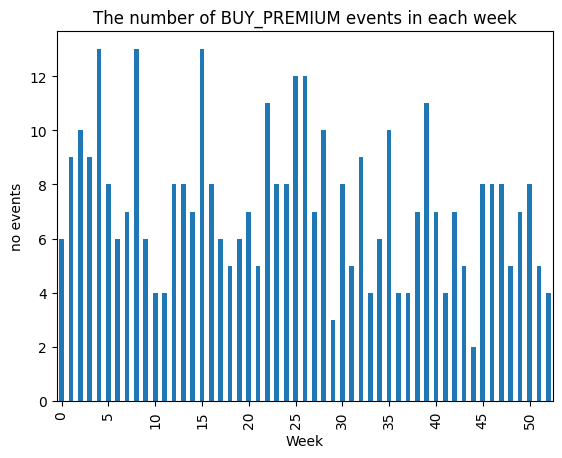

In [ ]:
# group by week and count the number of records in each week
weekly_counts = sessions_df[sessions_df['event_type'] == 'BUY_PREMIUM'].groupby(pd.Grouper(freq='W', key="timestamp"))['event_type'].count()
ax = weekly_counts.plot(kind="bar")
ax.set_title("The number of BUY_PREMIUM events in each week")
ax.set_xlabel("Week")
ax.set_ylabel("no events")

ax.set_xticks(range(0, len(weekly_counts), 5))
ax.set_xticklabels(range(0, len(weekly_counts), 5))

plt.show()

### Model bazowy klasyfikatora

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer


In [ ]:
mlb = MultiLabelBinarizer(sparse_output=True)
lb = LabelBinarizer()

users_df = users_df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(users_df.pop('favourite_genres')),
                index=users_df.index,
                columns=mlb.classes_))


users_df = users_df.join(
            pd.DataFrame(
                lb.fit_transform(users_df.pop('city')),
                index=users_df.index,
                columns=lb.classes_))

#### Sprawdzamy czy nie ma wartości pustych

In [ ]:
assert users_df.isna().sum().sum() == 0


In [ ]:
def calculate_ads_time(df):
    ads_mask = df.loc[:,'event_type'] == "ADVERTISEMENT"
    ads_time = np.timedelta64(0)
    for _, action in df.loc[ads_mask].iterrows():
        difference = action.next_timestamp - action.timestamp
        if difference < np.timedelta64(0):
            pass
        ads_time += difference
    return ads_time

#### Wyznaczanie stosunku między czasem reklam a czasem pozostałych akcji

In [ ]:

sessions_filtered = pd.DataFrame()

for user_id, user_actions in sessions_df.groupby('user_id'):
    user_bought_premium = False
    user_ads_time = np.timedelta64(0)
    user_all_time = np.timedelta64(0)
    
    for session_id, session in user_actions.groupby('session_id'):
        if user_bought_premium:
            break

        session.sort_values(by=['timestamp'])
        user_all_time += session["timestamp"].iat[-1] - session["timestamp"].iat[0]

        premium_bought_mask = session.loc[:,'event_type'] == "BUY_PREMIUM"
        bought_premium_in_session = premium_bought_mask.any()

        if bought_premium_in_session:
            time_of_buy_premium = session.loc[premium_bought_mask].timestamp.iloc[0]
            session = session.loc[session.loc[:, 'timestamp'] <= time_of_buy_premium]
            user_bought_premium = True
        
        sessions_filtered = pd.concat([sessions_filtered, session])
        session.loc[:, 'next_timestamp'] = session.loc[:, 'timestamp'].shift(-1, fill_value=session.loc[:,'timestamp'].max())

        user_ads_time += calculate_ads_time(session)
    
    # ads_time = np.sum((user_actions.loc[ads_mask]["next_timestamp"] - user_actions.loc[ads_mask].index)/ np.timedelta64(1, 's'))
   
    session_times_df = pd.DataFrame(
        {
            'all_time': user_all_time/ np.timedelta64(1, 's'),
            'ads_time': user_ads_time/ np.timedelta64(1, 's'), 
         },
            index=[user_id], 
    )
    time_comparison_df = pd.concat([time_comparison_df, session_times_df])
    

In [ ]:
users_df = users_df.join(
    pd.DataFrame(data=time_comparison_df.loc[:,'ads_time']/time_comparison_df.loc[:,'all_time'], columns=["Ads_ratio"]),
    on="user_id")


#### K najbliższych sąsiadów jako klasyfikator bazowy

In [ ]:
X = users_df.drop(["premium_user", "street", "name", "user_id"], axis=1) 
y = users_df.loc[:, "premium_user"] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
kneigh = NearestCentroid()
kneigh.fit(X_train, y_train)

y_hat = kneigh.predict(X_test)
score = accuracy_score(y_test, y_hat)
score 

## Wnioski

### Pierwsza wersja danych
Do naszych potrzeb najbardziej użyteczne będą pliki *users.json* i *sessions.json*.
Dodatkowo w celu identyfikacji gatunku używane będą pliki *tracks.json* i *artists.json*.

Wspólne defekty danych:
- wiele brakujących wartości (null),
- mała ilość danych,
- niereprezentatywne dane.

Dodatkowo:
1. Plik users.json:
    - Atrybut o nazwie "id" ma niedeskryptywną nazwę oraz jest obecny tylko w kilku próbkach.
    - Brak jednoznacznego oznaczania lokalizacji - aleja -> al., ulica -> ul.

2. Plik sessions.json:
    - Niektóre sesje trwają 0 sekund,
    - Brak wartości "event_type" dla reklam.

### Druga wersja danych

Wspólne cechy danych:
- brak wartości null,
- mała ilość danych,
- niereprezentatywne dane.

Dodatkowo:
1. Plik users.json:
    - Atrybut o nazwie "id" ma niedeskryptywną nazwę oraz jest obecny tylko w kilku próbkach.
    - Brak jednoznacznego oznaczania lokalizacji - aleja -> al., ulica -> ul.

2. Plik sessions.json:
    - Niektóre sesje trwają 0 sekund,
    - Brak wartości "event_type" dla reklam,